In [181]:
import bisect
from dataclasses import dataclass, field
from typing import Tuple

import numpy as np
import scipy as sp
import sympy as sym
from hybrid_ode_sim.simulation.ode_solvers.fixed_step_solver import RK4

from hybrid_ode_sim.simulation.base import (ContinuousTimeModel,
                                            DiscreteTimeModel)
from hybrid_ode_sim.simulation.simulator import (ModelGraph,
                                                 SimulationEnvironment,
                                                 Simulator)

from hybrid_ode_sim.utils.logging_tools import LogLevel
from scipy.interpolate import interp1d
from spatialmath.base import (exp2r, q2r, qconj, qdotb, qnorm, qqmul, qslerp,
                              qunit, qvmul, r2q, skewa, skew, qeye, qrand)

import uav_control.constants as constants
from uav_control.constants import (OMEGA_B0_B, OMEGA_B0_B_DIM, Q_NB, Q_NB_DIM,
                                   R_B0_N, R_B0_N_DIM, TAU_B0_B, TAU_B0_B_DIM,
                                   THRUST, THRUST_DIM, V_B0_N, V_B0_N_DIM,
                                   a_g_N, compose_state, compose_state_dot,
                                   decompose_control, decompose_state, e3,
                                   thrust_axis_B)
from uav_control.utils.math import (compute_cross_product_dot,
                                    compute_unit_vector_ddot,
                                    compute_unit_vector_dot, dxu_dx_jacobian,
                                    sym_Aq, sym_Gq, sym_H, sym_Lq, sym_Rq,
                                    sym_skewsym, vee)

In [182]:
# Write out symbolic equations of motion for the rigid body orientation dynamics
q_err = sym.symbols('q_err:4')
omega_err = sym.symbols('omega_err:3')

q_err = sym.Matrix(q_err)
omega_err = sym.Matrix(omega_err)

q_err_dot = 1/2 * sym_Lq(q_err) @ sym_H @ omega_err
dq_err_dot__domega_err = q_err_dot.jacobian(omega_err)
dq_err_dot__dq_err = q_err_dot.jacobian(q_err)

In [183]:
@dataclass
class RigidBodyDynamicsParams:
    J: np.ndarray = field(default=np.eye(3))
    J_inv: np.ndarray = field(init=False)
    
    def __post_init__(self):
        self.J_inv = np.linalg.inv(self.J)


class RigidBodyOrientationDynamics(ContinuousTimeModel):
    def __init__(self, y0, params: RigidBodyDynamicsParams,
                 name = "rigid_body_orientation_dynamics",
                 logging_level=LogLevel.ERROR):
        super().__init__(y0, name, params, logging_level)
        
        self.omega_b0_B_dot = np.zeros(OMEGA_B0_B_DIM)
        
    @staticmethod
    def _stack_state(q_NB, omega_b0_B):
        return np.concatenate((q_NB, omega_b0_B))
    
    def output_validate(self, y: np.ndarray) -> np.ndarray:
        q_NB = y[0:Q_NB_DIM]
        omega_b0_B = y[Q_NB_DIM:]
            
        return self._stack_state(qunit(q_NB), omega_b0_B)
    
    def continuous_dynamics(self, t, y):
        tau_b0_B = self.input_models["bodyrate_torque_controller"].y
        
        q_NB = qunit(y[0:Q_NB_DIM])
        omega_b0_B = y[Q_NB_DIM:]
        
        omega_b0_B_dot = self.params.J_inv @ (tau_b0_B - np.cross(omega_b0_B, self.params.J @ omega_b0_B))
        q_NB_dot = 1/2 * qdotb(q_NB, omega_b0_B)
        
        self.omega_b0_B_dot = omega_b0_B_dot
        
        return self._stack_state(q_NB_dot, omega_b0_B_dot)


class OrientationPlanner(DiscreteTimeModel):
    def __init__(self, y0, sample_rate, 
                 name = "orientation_planner",
                 params=[qeye(), 1.0],
                 logging_level=LogLevel.ERROR):
        super().__init__(y0, sample_rate, name, params, logging_level)
        self.q_prev = self.params[0]
    
    def discrete_dynamics(self, t, y):
        q_NF = self.params[0]
        t_f = self.params[1]

        q_ND = qslerp(qeye(), q_NF, min(1.0, t/t_f), shortest=True)
        
        q_dot = 1/self.sample_rate * (q_ND - self.q_prev)
        omega_d0_D = 2 * qqmul(qconj(q_ND), q_dot)[1:]
        
        self.q_prev = q_ND
        
        planner_out = np.concatenate((q_ND, omega_d0_D))
        return planner_out

@dataclass
class OrientationLQRControllerParams:
    Q: np.ndarray = np.eye(3)
    R: np.ndarray = np.eye(3)
    R_inv: np.ndarray = field(init=False)
    
    def __post_init__(self):
        self.R_inv = np.linalg.inv(self.R)

class OrientationLQRController(DiscreteTimeModel):
    def __init__(self, y0, sample_rate,
                 name="orientation_lqr_controller",
                 params=OrientationLQRControllerParams(),
                 logging_level=LogLevel.ERROR):
        super().__init__(y0, sample_rate, name, params, logging_level)
    
    @staticmethod
    def _q_err_shortest(qd, q):
        q_err = qqmul(qconj(qd), q)
        if q_err[0] < 0:
            q_err = -q_err
        return q_err
    
    def discrete_dynamics(self, t, y):
        # Vector part of the quaternion is the state, angular velocity is the control
        x_curr = self.input_models["rigid_body_orientation_dynamics"].y
        x_des = self.input_models["orientation_planner"].y
        
        q_NB, omega_b0_B = x_curr[0:Q_NB_DIM], x_curr[Q_NB_DIM:]
        q_ND, omega_d0_D = x_des[0:Q_NB_DIM], x_des[Q_NB_DIM:]
        
        q_BD = qqmul(qconj(q_NB), q_ND)
        omega_d0_B = qvmul(q_BD, omega_d0_D)
        
        q_err = self._q_err_shortest(q_ND, q_NB)
        q_err_vec = q_err[1:]
        omega_err = omega_b0_B - omega_d0_B
        
        # A matrix
        dq_err_dot__dq_err = -1/2 * skew(omega_err)
        A = dq_err_dot__dq_err

        # B matrix
        dq_err_dot__domega_err = 1/2 * (q_err[0] * np.eye(3) + skew(q_err[1:]))
        B = dq_err_dot__domega_err
        
        P = sp.linalg.solve_continuous_are(A, B, self.params.Q, self.params.R)
        K = self.params.R_inv @ B.T @ P
        
        # delta u = -K * delta_x
        delta_u = -K @ q_err_vec
        u = delta_u + omega_d0_B
                
        return u


@dataclass
class BodyrateControllerParams:
    Kp: np.ndarray = np.eye(3)
    Kd: np.ndarray = np.eye(3)


class BodyrateController(DiscreteTimeModel):
    def __init__(self, y0, sample_rate,
                 params: BodyrateControllerParams,
                 rbd_params: RigidBodyDynamicsParams,
                 name="bodyrate_torque_controller", logging_level=LogLevel.ERROR):
        super().__init__(y0, sample_rate, name, params, logging_level)
        self.rbd_params = rbd_params
    
    def discrete_dynamics(self, t, y):
        omega_d0_B = self.input_models["orientation_lqr_controller"].y
        rb_state = self.input_models["rigid_body_orientation_dynamics"].y
        
        _q_NB = rb_state[0:Q_NB_DIM]
        omega_b0_B = rb_state[Q_NB_DIM:]
        omega_b0_B_dot = self.input_models["rigid_body_orientation_dynamics"].omega_b0_B_dot
        
        # Compute the desired angular acceleration based on PD controller
        omega_c0_B_dot = self.params.Kp @ (omega_d0_B - omega_b0_B) + self.params.Kd @ (-omega_b0_B_dot)
        
        # Compute the torque, feedback linearization-style
        tau_b0_B = self.rbd_params.J @ omega_c0_B_dot + np.cross(omega_b0_B, self.rbd_params.J @ omega_b0_B)
        
        return tau_b0_B

In [213]:
t_range = [0, 4.0]
q_des = qrand()
q_0 = qeye()

sample_rate = 100

rigid_body_params = RigidBodyDynamicsParams(
    J = np.diag([0.01, 0.01, 0.1])
)

dynamics = RigidBodyOrientationDynamics(y0=RigidBodyOrientationDynamics._stack_state(q_0, np.zeros(3)),
                                        params=rigid_body_params)

planner = OrientationPlanner(y0=q_0, sample_rate=sample_rate,
                             params=(q_des, t_range[-1] - 1.0))

lqr_controller = OrientationLQRController(y0=np.zeros(3),
                                          sample_rate=sample_rate // 5,
                                          params=OrientationLQRControllerParams(
                                              Q = np.eye(3),
                                              R = 0.001 * np.eye(3),
                                          ))

bodyrate_controller = BodyrateController(y0=np.zeros(3),
                                         sample_rate=sample_rate,
                                         params=BodyrateControllerParams(
                                             Kp = 8.0 * np.eye(3),
                                             Kd = 0.2 * np.eye(3),
                                         ),
                                         rbd_params=rigid_body_params)

planner.inputs_to(lqr_controller)
lqr_controller.inputs_to(bodyrate_controller)
bodyrate_controller.inputs_to(dynamics)

lqr_controller.feedback_from(dynamics)
bodyrate_controller.feedback_from(dynamics)

model_graph = ModelGraph(
    models=[
        lqr_controller,
        bodyrate_controller,
        dynamics,
        planner
    ]
)

# Run simulation
env = SimulationEnvironment(
    simulator=Simulator(model_graph, RK4(h=0.001))
).run_simulation(t_range=t_range)

[Simulator] INFO: Simulation Complete! Elapsed Time: 0.56 s (7.18x real-time)


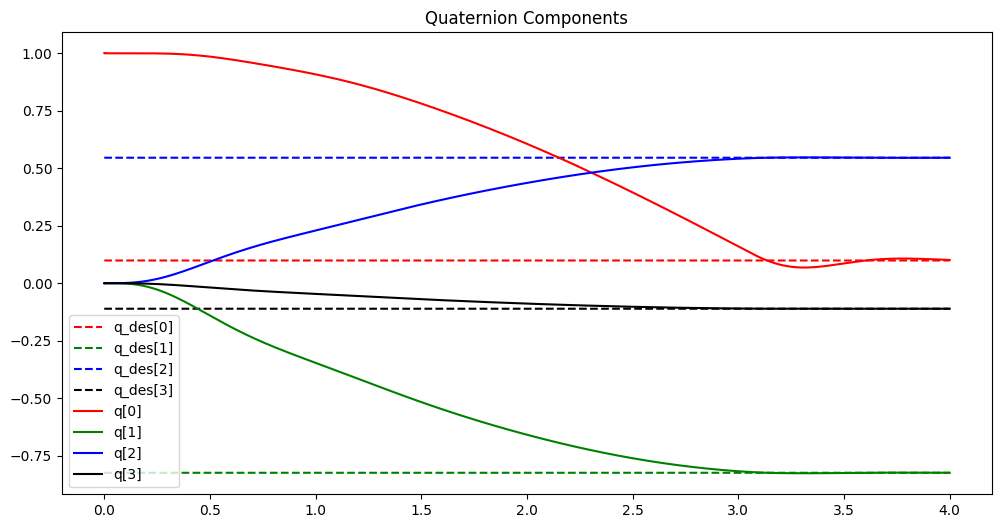

In [214]:
ts, ys, history_fn = dynamics.history()
ys = np.array(ys)

import matplotlib.pyplot as plt

# Plot the desired and actual quaternion components over time
plt.figure(figsize=(12, 6))

plt.title('Quaternion Components')

plt.plot(ts, q_des[0] * np.ones_like(ts), label='q_des[0]', color='r', linestyle='--')
plt.plot(ts, q_des[1] * np.ones_like(ts), label='q_des[1]', color='g', linestyle='--')
plt.plot(ts, q_des[2] * np.ones_like(ts), label='q_des[2]', color='b', linestyle='--')
plt.plot(ts, q_des[3] * np.ones_like(ts), label='q_des[3]', color='k', linestyle='--')

plt.plot(ts, ys[:, 0], label='q[0]', color='r')
plt.plot(ts, ys[:, 1], label='q[1]', color='g')
plt.plot(ts, ys[:, 2], label='q[2]', color='b')
plt.plot(ts, ys[:, 3], label='q[3]', color='k')

plt.legend()
plt.show()